In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

# Paths

In [2]:
data_root = '../../data/'
log_root = './logs/'

# Dataset

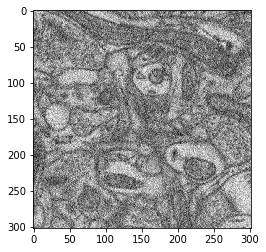

In [3]:
# Let's look at some data
img = plt.imread(os.path.join(data_root, '2016-05-26_st015_000303_000_003_000_n_00_crop_000.tif'))
plt.imshow(img, cmap='gray');

In [4]:
# Let's get a quick-and-dirty estimate of image summary stats
norm_params = {'mean': np.mean(img), 'std': np.std(img)}

## Define Dataset subclass

In [5]:
class SBEMCrop2dDataset(Dataset):
    
    def __init__(self, data_root, norm_params):
        self.data_fnames = os.listdir(data_root)
        self.data_root = data_root
        self.norm_params = norm_params
    
    def __len__(self):
        return len(self.data_fnames)
    
    def __getitem__(self, idx):
        img = np.asarray(plt.imread(os.path.join(self.data_root, self.data_fnames[idx])))
        img = self._normalize(img)
        sample = SBEMCrop2dDataset._reshape_to_torch(img)
        return sample
    
    def _normalize(self, img):
        img = (np.asarray(img)-self.norm_params['mean'])/self.norm_params['std']
        return img
    
    @staticmethod
    def _reshape_to_torch(img):
        sample = torch.from_numpy(np.reshape(img, (1, img.shape[0], img.shape[1]))).float()
        return sample

## Instantiate dataset subclass

In [6]:
sbem_dataset = SBEMCrop2dDataset(data_root, norm_params)

## Test dataset subclass

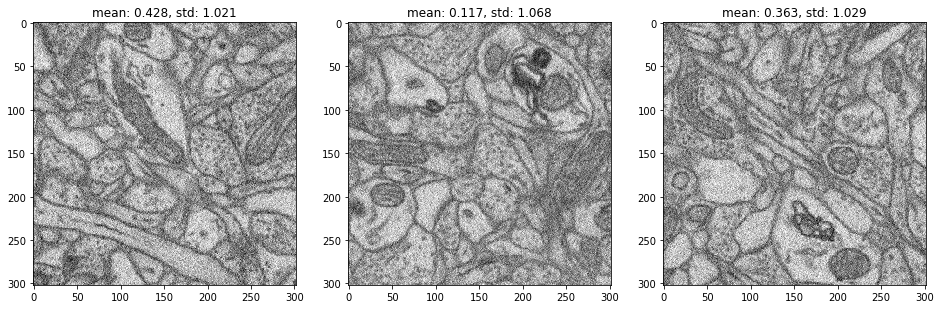

In [7]:
# Show first 3 images in dataset
fig, axs = plt.subplots(1, 3, figsize=(16,12))

for i in range(3):
    sample = sbem_dataset[i]
    img = sample.data.numpy().squeeze()
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title('mean: {:0.3f}, std: {:0.3f}'.format(np.mean(img), np.std(img)))

In [8]:
img.dtype

dtype('float32')

# Model

## Define Model

In [9]:
class ConvAE2D(torch.nn.Module):
    def __init__(self):
        super(ConvAE2D, self).__init__()
        self.encoding_layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.encoding_pool1 = torch.nn.MaxPool2d(2)
        self.encoding_layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.encoding_pool2 = torch.nn.MaxPool2d(2)
        self.encoding_layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.decoding_layer1 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(4, 8, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.decoding_up1 = torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.decoding_layer2 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(8, 16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU())
        self.decoding_up2 = torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.decoding_layer3 = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=0),
            torch.nn.Sigmoid())
        
    def forward(self, x):
        x = self.encoding_layer1(x)
        x = self.encoding_pool1(x)
        x = self.encoding_layer2(x)
        x = self.encoding_pool2(x)
        x = self.encoding_layer3(x)
        x = self.decoding_layer1(x)
        x = self.decoding_up1(x)
        x = self.decoding_layer2(x)
        x = self.decoding_up2(x)
        x = self.decoding_layer3(x)
        return x

## Instantiate Model, Loss and Optimizer

In [10]:
net = ConvAE2D()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

## Utility functions

In [11]:
def data2fig_subplot(inputs, outputs, idx):
    fig, axs = plt.subplots(1, 2, figsize=(16,12))
    img_input = inputs[idx].data.numpy().squeeze()
    axs[0].imshow(img_input, cmap='gray')
    img_output = outputs[idx].data.numpy().squeeze()
    axs[1].imshow(img_output, cmap='gray')
    return fig

# Train Model

In [12]:
trainloader = DataLoader(sbem_dataset, batch_size=3, shuffle=True, num_workers=0)
writer = SummaryWriter(log_root)
writer_int = 10
n_epoch = 30
it = 0
for epoch in range(n_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        it += 1
        # get the inputs; data is a list of [inputs, labels]
        inputs = data
        labels = inputs

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % writer_int == writer_int-1:
            
            avg_loss = running_loss / writer_int
            
            print('it: {} (epoch: {}, batch: {}), running loss: {:0.3f}'.format(it, epoch, i+1, avg_loss))
            
            writer.add_scalar('loss', loss.item(), it)
            writer.add_scalar('avg_loss', avg_loss, it)
            writer.add_figure('inputs', data2fig_subplot(inputs, outputs, 0), it)
            
            running_loss = 0.0

it: 10 (epoch: 0, batch: 10), running loss: 1.150
it: 20 (epoch: 0, batch: 20), running loss: 1.134
it: 30 (epoch: 1, batch: 10), running loss: 1.131
it: 40 (epoch: 1, batch: 20), running loss: 1.120
it: 50 (epoch: 2, batch: 10), running loss: 1.131
it: 60 (epoch: 2, batch: 20), running loss: 1.116
it: 70 (epoch: 3, batch: 10), running loss: 1.111
it: 80 (epoch: 3, batch: 20), running loss: 1.083
it: 90 (epoch: 4, batch: 10), running loss: 0.977
it: 100 (epoch: 4, batch: 20), running loss: 0.845
it: 110 (epoch: 5, batch: 10), running loss: 0.830
it: 120 (epoch: 5, batch: 20), running loss: 0.818
it: 130 (epoch: 6, batch: 10), running loss: 0.795
it: 140 (epoch: 6, batch: 20), running loss: 0.782
it: 150 (epoch: 7, batch: 10), running loss: 0.768
it: 160 (epoch: 7, batch: 20), running loss: 0.768
it: 170 (epoch: 8, batch: 10), running loss: 0.770
it: 180 (epoch: 8, batch: 20), running loss: 0.746
it: 190 (epoch: 9, batch: 10), running loss: 0.753
it: 200 (epoch: 9, batch: 20), running l

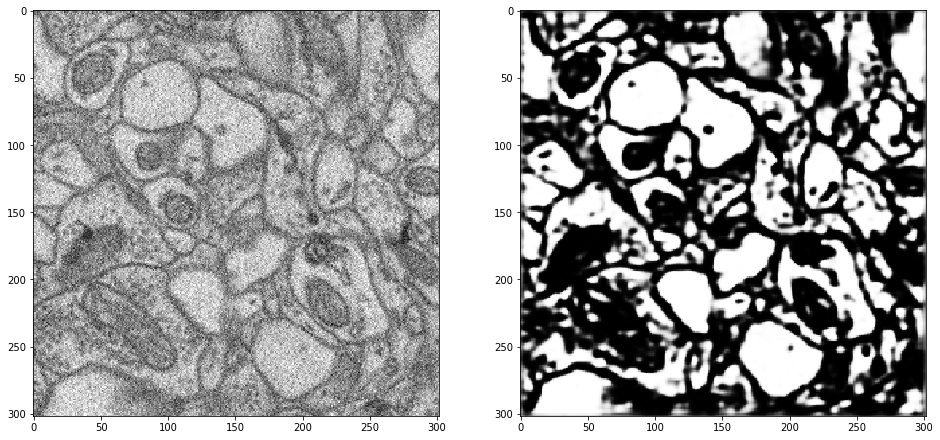

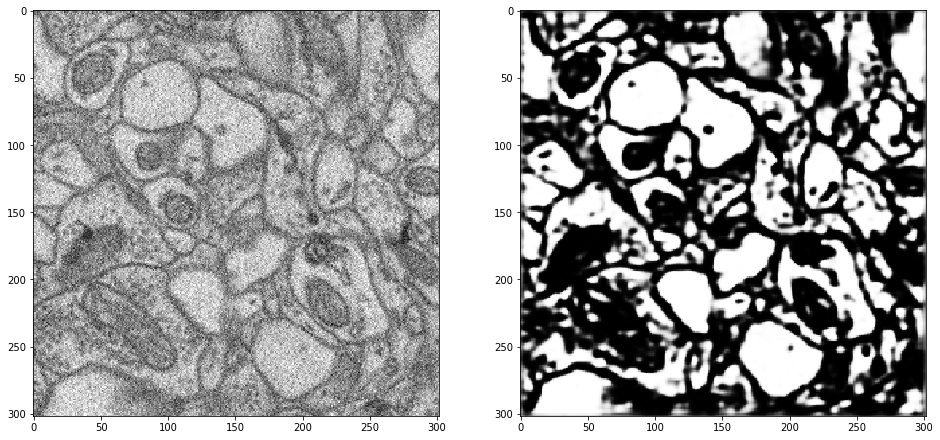

In [13]:
# Show input vs output
data2fig_subplot(inputs, outputs, 0)

(array([36334.,  4722.,  3246.,  2694.,  2246.,  2178.,  2218.,  2635.,
         3683., 31248.]),
 array([1.17920315e-07, 9.99980643e-02, 1.99996024e-01, 2.99993962e-01,
        3.99991930e-01, 4.99989867e-01, 5.99987805e-01, 6.99985743e-01,
        7.99983740e-01, 8.99981678e-01, 9.99979615e-01], dtype=float32),
 <a list of 10 Patch objects>)

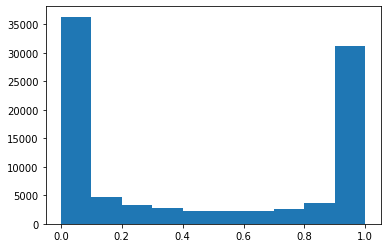

In [21]:
plt.hist(outputs[0].data.numpy().flatten())